Google Docs link: https://docs.google.com/document/d/1pbRxDIas8X6eFYFKzOoWA39CKK2lLKj4VAVrgC1k-n0/edit

In [ ]:
import pandas as pd
import glob
import numpy as np
from functools import reduce
import time
import datetime
import math
pd.set_option("display.max_columns", None)

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Imports and upgrades for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Read Kaggle datasets
kaggle_data = drive.CreateFile({'id': '1d255xxpiPJ_xal0c90TzULyAu6Iuuorz'}) 
kaggle_data.GetContentFile('data2.zip')

!unzip data2.zip
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

Archive:  data2.zip
  inflating: train.csv               
  inflating: test.csv                
  inflating: sample_submission.csv   


In [ ]:
# Read "riigipühad.csv"
riigipühad_data = drive.CreateFile({'id': '1DLzI3WqPXhqMXZ1xL8dd80pAWMJmIjAY'})
riigipühad_data.GetContentFile('riigipühad.csv')

riigipühad = pd.read_csv('riigipühad.csv')

In [ ]:
# Process national holidays data
riigipühad['date'] = [datetime.datetime.strptime(d, "%Y-%m-%d") for d in riigipühad["date"]]

riigipühad['Year'] = [d.year for d in riigipühad['date']]
riigipühad['Month'] = [d.month for d in riigipühad['date']]
riigipühad['Day'] = [d.day for d in riigipühad['date']]

riigipühad.drop(['date', 'title', 'notes', 'kind'], axis = 1, inplace = True)

riigipühad.head()

,kind_id,Year,Month,Day
0,1,2021,1,1
1,3,2021,1,6
2,3,2021,2,2
3,4,2021,2,23
4,2,2021,2,24


In [ ]:
# Read "sunrise.csv"
sunrise_data = drive.CreateFile({'id': '1AzdMuk2JUl2zQ9LP7hMYWMXH2OKcW-VA'})
sunrise_data.GetContentFile('sunrise.csv')

sunrise = pd.read_csv('sunrise.csv')

In [ ]:
# Process sunrise data
sunrise['date'] = [datetime.datetime.strptime(d, "%m/%d/%Y") for d in sunrise["date"]]
sunrise['sunrise'] = [datetime.datetime.strptime(d, "%H:%M:%S %p") for d in sunrise["sunrise"]]
sunrise['sunset'] = [datetime.datetime.strptime(d, "%H:%M:%S %p") for d in sunrise["sunset"]]

sunrise['sunrise'] = [d.hour for d in sunrise['sunrise']]
sunrise['sunset'] = [d.hour + 12 for d in sunrise['sunset']]
sunrise['Month'] = [d.month for d in sunrise['date']]
sunrise['Day'] = [d.day for d in sunrise['date']]
sunrise.drop(['Unnamed: 0', 'date', 'duration'], axis = 1, inplace = True)

sunrise.head()

,sunrise,sunset,Month,Day
0,9,15,1,1
1,9,15,1,2
2,9,15,1,3
3,9,15,1,4
4,9,15,1,5


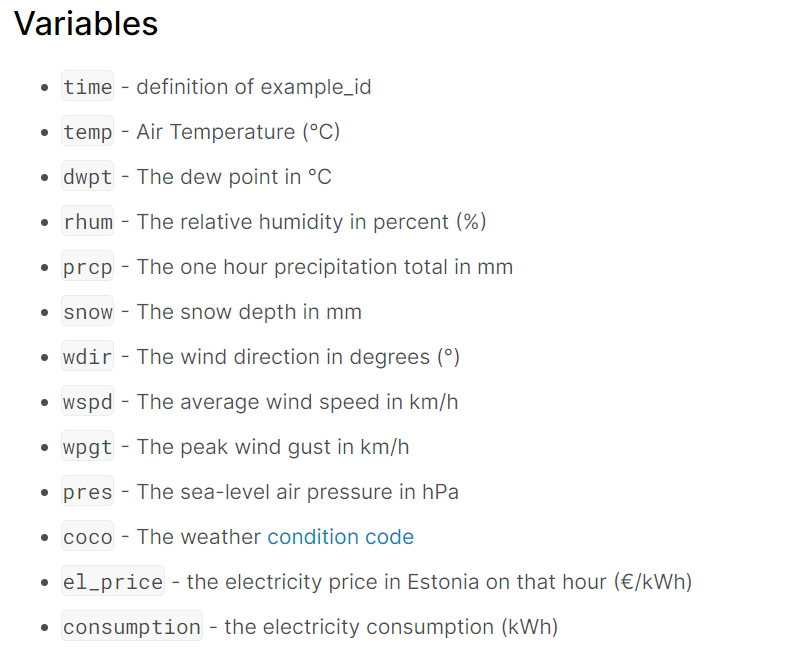

# **Step 1 - Preprocessing**

**Initial look at the data:**

In [ ]:
train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,NaN,NaN,320.0,7.2,16.7,1012.6,2.0,0.09016,0.577
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,NaN,NaN,320.0,7.2,13.0,1012.6,2.0,0.09251,0.594
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,NaN,NaN,320.0,7.2,13.0,1012.2,2.0,0.08890,0.685
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,NaN,NaN,330.0,7.2,13.0,1011.9,1.0,0.08735,1.016
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,NaN,NaN,300.0,3.6,13.0,1011.4,2.0,0.08688,0.677


In [ ]:
test.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price
0,2022-08-25 00:00:00+03:00,21.1,15.2,69.0,0.0,NaN,340.0,9.0,9.3,1022.0,2.0,0.25533
1,2022-08-25 01:00:00+03:00,20.1,15.1,73.0,0.0,NaN,30.0,6.0,14.8,1022.0,2.0,0.19492
2,2022-08-25 02:00:00+03:00,20.1,15.1,73.0,0.0,NaN,320.0,7.0,13.0,1022.0,2.0,0.18853
3,2022-08-25 03:00:00+03:00,18.7,17.0,90.0,0.0,NaN,0.0,4.0,11.1,1022.4,4.0,0.19947
4,2022-08-25 04:00:00+03:00,18.1,17.1,94.0,0.0,NaN,280.0,7.0,11.1,1022.0,3.0,0.21192


In [ ]:
sample.head()

,time,consumption
0,2022-08-25 00:00:00+03:00,0.546
1,2022-08-25 01:00:00+03:00,1.817
2,2022-08-25 02:00:00+03:00,1.880
3,2022-08-25 03:00:00+03:00,1.000
4,2022-08-25 04:00:00+03:00,1.118


Create function to preprocess dataset:

In [ ]:
def add_suntime(data):
  data = data.merge(sunrise, on = ['Day', 'Month'], how = 'left')
  data['sun'] = (data['Hour'] > data['sunrise']).astype(int)
  data.drop(['sunrise', 'sunset'], axis = 1, inplace = True)
  return data

In [ ]:
def add_riigipühad(data):
  data = data.merge(riigipühad, on = ['Day', 'Month', 'Year'], how = 'left')
  data['riigipyha'] = data['kind_id']
  data.drop('kind_id', axis = 1, inplace = True)
  data['riigipyha'].fillna(0, inplace = True)
  return data

In [ ]:
def add_koolivaheajad(data):
  koolivaheaja_algused = [
      (25, 10, 2021),
      (23, 12, 2021),
      (28, 2, 2022),
      (25, 4, 2022),
      (14, 6, 2022),
      (24, 10, 2022),
      (22, 12, 2022)
  ]
  koolivaheaja_lõpud = [
      (31, 10, 2021),
      (9, 1, 2022),
      (6, 3, 2022),
      (1, 5, 2022),
      (31, 8, 2022),
      (30, 10, 2022),
      (8, 1, 2023)
  ]
  koolivaheaeg = []
  for i in range(len(data)):
    on_vaheaeg = False
    row = data.iloc[i, :]
    for j in range(len(koolivaheaja_algused)):
      algus = koolivaheaja_algused[j]
      lõpp = koolivaheaja_lõpud[j]
      algus_int = algus[2] * 10000 + algus[1] * 100 + algus[0]
      lõpp_int = lõpp[2] * 10000 + lõpp[1] * 100 + lõpp[0]
      row_int = row.Year * 10000 + row.Month * 100 + row.Day
      if row_int >= algus_int and row_int <= lõpp_int:
        koolivaheaeg.append(1)
        on_vaheaeg = True
    if not on_vaheaeg:
      koolivaheaeg.append(0)
  data['koolivaheaeg'] = koolivaheaeg
  return data


In [ ]:
def preprocess(data):

  # Create copy of dataset instead of applying changes directly
  data = data.copy()

  # Convert time column to datetime datatype
  data['time'] = [datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S%z") for d in data["time"]]

  # Split time dimension into different parts
  data['Hour'] = [datetime.datetime.time(d).hour for d in data['time']]
  data['Year'] = [d.year for d in data['time']]
  data['Month'] = [d.month for d in data['time']]
  data['Day'] = [d.day for d in data['time']]
  data['Weekday'] = [d.weekday() for d in data['time']] # 0 = Monday, ..., 6 = Sunday

  # Apply snow depth to all hours of the day
  data['snow'].fillna(0, inplace=True)
  snow = data.groupby(['Year', 'Month', 'Day'])['snow'].max()
  data['snow'] = np.repeat(list(snow), 24)

  # Fill missing values with 0-s for precipitation
  data['prcp'].fillna(0, inplace=True)

  # Drop unnecessary columns
  data = data.drop(['time', 'coco'], axis=1)

  # Drop rows with NA values ('Consumption' is missing)
  data.dropna(inplace=True)

  data = add_suntime(data)
  data = add_riigipühad(data)
  data = add_koolivaheajad(data)

  return data

In [ ]:
# Create preprocessed datasets

train_preprocessed = preprocess(train)
test_preprocessed = preprocess(test)

In [ ]:
train_preprocessed.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,el_price,consumption,Hour,Year,Month,Day,Weekday,sun,riigipyha,koolivaheaeg
0,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,0.09016,0.577,0,2021,9,1,2,0,0.0,0
1,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,0.09251,0.594,1,2021,9,1,2,0,0.0,0
2,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,0.08890,0.685,2,2021,9,1,2,0,0.0,0
3,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,0.08735,1.016,3,2021,9,1,2,0,0.0,0
4,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,0.08688,0.677,4,2021,9,1,2,0,0.0,0


In [ ]:
# Create train-test split from training data for model validation
from sklearn.model_selection import train_test_split

X = train_preprocessed.drop('consumption', axis=1)
y = train_preprocessed['consumption']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)


# **Step 2 - Modelling**

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score

# Decision Tree Regressor model

In [ ]:
# Grid search logic based on https://www.programcreek.com/python/example/91151/sklearn.model_selection.GridSearchCV
# Example no 3.

model = DecisionTreeRegressor()

parameters = {
    'max_depth': [8],
    'max_features': [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
    }


clf = GridSearchCV(model, param_grid=parameters, scoring='neg_mean_absolute_error', n_jobs = -1)
grid_search = clf.fit(train_X, train_y)

print("Best score: %0.3f" % grid_search.best_score_)
print(grid_search.best_estimator_)

# best prarams
print('best prarams:', clf.best_params_)

print('-----grid search end------------')
print('on all train set')
scores = cross_val_score(grid_search.best_estimator_, train_X, train_y, cv=5, scoring='neg_mean_absolute_error')
print(scores.mean(), scores)
print('on test set')
scores = cross_val_score(grid_search.best_estimator_, test_X, test_y, cv=5, scoring='neg_mean_absolute_error')
print(scores.mean(), scores) 

Best score: -0.537
DecisionTreeRegressor(max_depth=8, max_features=17)
best prarams: {'max_depth': 8, 'max_features': 17}
-----grid search end------------
on all train set
-0.5367626554290907 [-0.53803164 -0.51524849 -0.54246885 -0.56997113 -0.51809317]
on test set
-0.6340378900535913 [-0.64782142 -0.58104652 -0.7631248  -0.52808933 -0.65010737]


In [ ]:
# Final model (train on whole training set):

dtr = DecisionTreeRegressor(max_depth = 8)
dtr.fit(X, y)

DecisionTreeRegressor(max_depth=8)

# Random Forest Regressor model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(train_X, train_y)

predict = rfr.predict(test_X)
mean_absolute_error(test_y, predict)

0.47841206635622824

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, n_jobs = -1)

rf_random.fit(X, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [ ]:
rfr = RandomForestRegressor(n_estimators=1000, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=20, bootstrap=False)
rfr.fit(train_X, train_y)

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=1000)

In [ ]:
predict = rfr.predict(test_X)
mean_absolute_error(test_y, predict)

0.47435069302311944

In [ ]:
# Final model (train on whole training set):

rfr = RandomForestRegressor(n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=100, bootstrap=False)
rfr.fit(X, y)

KeyboardInterrupt: ignored

# Neural Network model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 32)                608       
                                                                 
 batch_normalization_6 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_14 (Dense)            (None, 24)                792       
                                                                 
 dropout_6 (Dropout)         (None, 24)                0         
                                                                 
 batch_normalization_7 (Batc  (None, 24)               96        
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 16)               

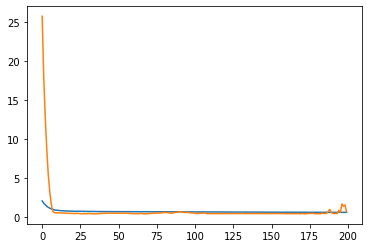

In [ ]:
# Based on https://www.datatechnotes.com/2018/12/rnn-example-with-keras-simplernn-in.html

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, BatchNormalization, Dropout
from keras.utils.vis_utils import plot_model

model = Sequential()
model.add(Dense(units=32, input_dim=18, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(24, activation="relu"))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(8, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
history = model.fit(X, y, epochs=200, batch_size=512, verbose=2, validation_split = 0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

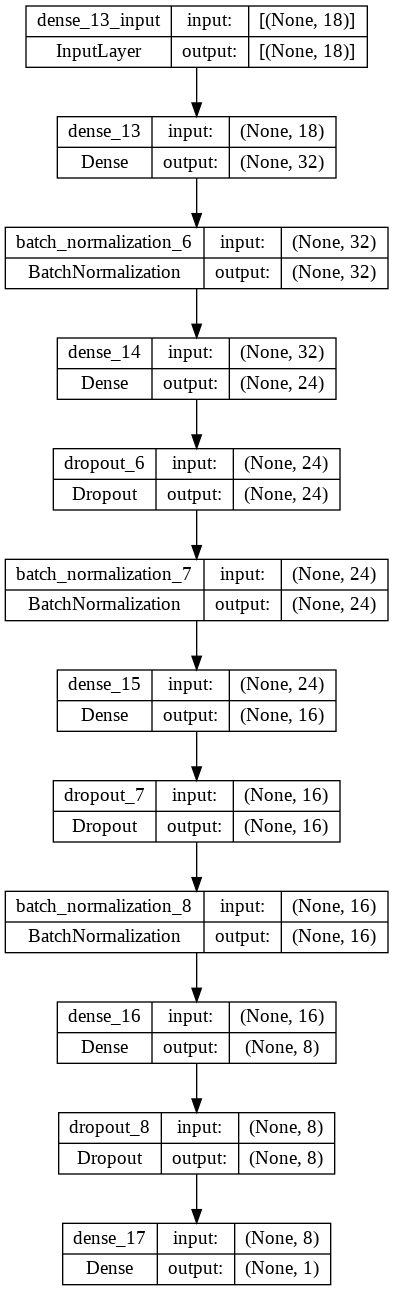

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

# XGBoost

In [ ]:
import xgboost as xgb

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(train_X, train_y,
        eval_set=[(train_X, train_y), (test_X, test_y)],
        early_stopping_rounds=50,
       verbose=0) 

[10:55:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

Index(['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'el_price', 'Hour', 'Year', 'Month', 'Day', 'Weekday', 'sun',
       'riigipyha', 'koolivaheaeg'],
      dtype='object')


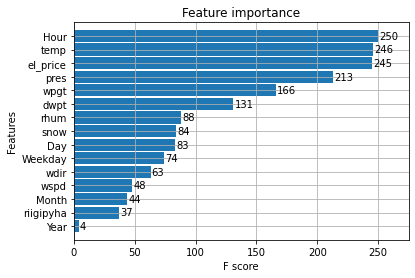

In [ ]:
from xgboost import plot_importance, plot_tree
print(train_X.columns)
_ = plot_importance(reg, height=0.9) 

In [ ]:
predicted = reg.predict(test_X)

mAbsErr = mean_absolute_error(y_true=test_y,
                   y_pred=predicted)
print("Mean Absolute Error: ", mAbsErr)

Mean Absolute Error:  0.5175754374967881


In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
def objective(space):
    reg=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( train_X, train_y), ( test_X, test_y)]
    
    reg.fit(train_X, train_y,
            eval_set=evaluation,
            early_stopping_rounds=10,verbose=False)
    

    predicted = reg.predict(test_X)
    mAbsErr = mean_absolute_error(y_true=test_y, y_pred=predicted)
    print ("SCORE:", mAbsErr)
    return {'loss': -mAbsErr, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

[10:55:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:
0.5939619465607009
[10:55:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:
0.5933528756332065
[10:55:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:
0.5915749081030436
[10:55:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:
0.584405228093839
[10:55:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:
0.5818574305965681
[10:55:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:
0.5792714768038918
[10:55:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is n

In [ ]:
print(best_hyperparams)

{'colsample_bytree': 0.5742013558278956, 'gamma': 7.603220045821237, 'max_depth': 15.0, 'min_child_weight': 1.0, 'reg_alpha': 180.0, 'reg_lambda': 0.07588967766617077}


In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000, colsample_bytree=0.5742013558278956, gamma=7.603220045821237, max_depth=15, min_child_weight=1, reg_alpha=180, reg_lambda=0.07588967766617077)
reg.fit(train_X, train_y,
        eval_set=[(train_X, train_y), (test_X, test_y)],
        early_stopping_rounds=50,
       verbose=0) 

[11:01:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.5742013558278956, gamma=7.603220045821237,
             max_depth=15, n_estimators=1000, reg_alpha=180,
             reg_lambda=0.07588967766617077)

Index(['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'el_price', 'Hour', 'Year', 'Month', 'Day', 'Weekday', 'sun',
       'riigipyha', 'koolivaheaeg'],
      dtype='object')


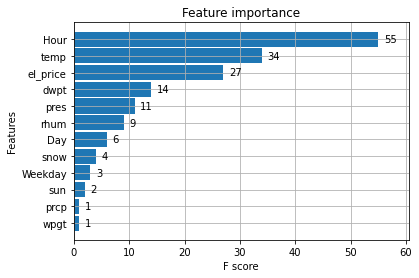

In [ ]:
from xgboost import plot_importance, plot_tree

print(train_X.columns)
_ = plot_importance(reg, height=0.9) 

In [ ]:
predicted = reg.predict(test_X)

mAbsErr = mean_absolute_error(y_true=test_y,
                   y_pred=predicted)
print("Mean Absolute Error: ", mAbsErr)

Mean Absolute Error:  0.5550895053665907


In [ ]:
dmatrix = xgb.DMatrix(data=X, label=y)

#params={'objective':'reg:squarederror'}
params={ 'objective':'reg:squarederror',
        'n_estimators':300,
         'max_depth': 6, 
         'colsample_bytree':0.7,
         'learning_rate':0.01}

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics={'mae'}, as_pandas=True, seed=20)
print('MAE: %.2f' % cv_results['test-mae-mean'].min())

MAE: 0.65


In [ ]:
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
xgbr = xgb.XGBRegressor()
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_absolute_error', 
                   verbose=1,
                   cv=3)
clf.fit(X, y)
print("Best parameters:", clf.best_params_)
print("Lowest MAE: ", clf.best_score_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[11:23:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:39] WARNING: /workspace/src/objective/regr

In [ ]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.5, 0.8]}
xgbr = xgb.XGBRegressor()
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_absolute_error', 
                   verbose=1,
                   cv=2)
clf.fit(X, y)
print("Best parameters:", clf.best_params_)
print("Lowest MAE: ", -clf.best_score_)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
[11:49:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:49:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:49:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:49:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:49:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:49:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:49:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:49:59] WARNING: /workspace/src/objective/regr

# Kaggle competition

In [ ]:
# Set up Kaggle connection
from google.colab import files

files.upload();

import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

Saving kaggle.json to kaggle.json
- path is now set to: {/content}


In [ ]:
# Function to create submissions file for Kaggle competition
def submit(model):
  predictions = model.predict(test_preprocessed).reshape(1, 168)[0]
  submission = sample.copy()
  submission['consumption'] = predictions
  submission.to_csv('submission.csv', index = False)


In [ ]:
# Choose model to use for predicting and submit to Kaggle:
submit(model) # NB! insert model name into brackets before running!

# Uncomment next line to submit (ONLY 5 SUBMISSIONS PER DAY)
!kaggle competitions submit -c predict-electricity-consumption -f submission.csv -m "Parim Masinõppe Projekt"

6/6 [==============================] - 0s 3ms/step
100% 5.94k/5.94k [00:00<00:00, 30.3kB/s]
Successfully submitted to Journey to zero - Predict electricity consumption